<table><tr>
<td> 
<td> <img src="https://npc-core.com/npc-content/uploads/2021/03/core-analysis-cores-combo.jpeg" alt="Drawing" style="width: 250px;"/> </td>
</tr></table>

<h1 align=center><font size = 4> Munish Kumar </font></h1>
<h1 align=center><font size = 4> UK Routine Core Analysis </font></h1>
<h1 align=center><font size = 3> 2022 </font></h1>

#### Libraries

In [1]:
# Only install the following libraries if you dont have it, otherwise leave it commented out

#!conda install -c anaconda natsort --yes
#!conda install -c anaconda xlrd --yes
#!pip install sympy --user

# General Libraries
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import NullFormatter
import time
import re
import requests
import pickle
import seaborn as sns
import os
import glob
import sys
from natsort import natsorted
sns.set()

# Sklearn Liraries
from sklearn import preprocessing

# For Latex style text
from sympy import S, symbols, printing

import datetime
from datetime import timedelta, date 
start = time.time()
%matplotlib inline

# Display max rows
pd.set_option('display.max_rows', 500)

# Forces the print statement to show everything and not truncate
# np.set_printoptions(threshold=sys.maxsize) 
print('Libraries imported')

Libraries imported


###### Declare some global variables

In [2]:
dir_name = r'C:\Users\mkumar\Documents\GitHub\munishkumar-gh.github.io\@Papers\Papers_SUSS\Core_Analysis_UK'
filename_suffix = 'csv'

###### Series of Functions

In [3]:
# Function to look at first 5 and last 5 elements in a dataframe
def ends(df, x=5):
    return df.head(x).append(df.tail(x))
setattr(pd.DataFrame,'ends',ends)

In [4]:
# Function to read out file
def file_out(df, dir_name, base_filename, filename_suffix):
    try:
        csvs_sht = os.path.join(dir_name, base_filename + "." + filename_suffix)
        df.to_csv(csvs_sht, index = False, header=True)
        print ("Final File Extract Produced")
    except IOError:
        print("I/O error")
    return

In [5]:
# Function to search for a text string
def search_words(text):
    result = re.findall(r'\b[^\d\W]+\b', text)
    return " ".join(result)

In [6]:
# Function to plot grain density
def plot_grain_density(mod_df, title, bins, xmin, xmax, savefn):
    sns.set()
    sns.set_style("whitegrid")     
    sns.set_style("ticks", 
                  {"xtick.major.size":size,
                  "ytick.major.size":size}
                 )
    sns.axes_style("whitegrid")
    kwargs = {'cumulative': True}

    ax = sns.distplot(mod_df, 
                      bins = bins, 
                      kde=False, 
                      norm_hist=False, 
                      color = 'r',
                      #bw_adjust=.25,
                      #hist_kws=kwargs, 
                      #kde_kws=kwargs
                     )

    ax.set(ylabel='Frequency', 
           #xlabel='common ylabel',
           xlim = (xmin, xmax),
          )

    ax.legend(labels=['Histogram', 'Frequency'])
    plt.title(title)
    plt.grid(True)

    plt.savefig(savefn, transparent=True)
    return

In [7]:
# Plotting the effect of NOBP
def plot_NOBP(mod_df, df_sub, grouped, color, savefn):
    # Plot per group
    fig = plt.figure(figsize=(14, 8))
    ax = fig.add_subplot(121)

    for i, (name, group) in enumerate(grouped):
        sc = ax.scatter(
            group["NOB (psi)"],
            group["Porosity (%)"],
            s = markersize**2,
            alpha=0.5,
            label=name,
            edgecolors = edgecolors,
        )  

    # Add legends (one for gender, other for size)
    ax.add_artist(ax.legend(title='Well Name'))
    ax.legend(*sc.legend_elements("colors", num=6))
    ax.set_xlabel('Net Overburden Pressure (psi)', fontsize=size)
    ax.set_ylabel('Porosity (%)', fontsize=size)

    plt.xticks(rotation = rotation, fontsize=size)
    plt.yticks(rotation = rotation, fontsize=size)
    plt.ylim(0,20) 
    plt.grid(True)
    
    ax1 = fig.add_subplot(122)

    for i, (name, group) in enumerate(grouped):
        sc1 = ax1.scatter(
            group["NOB (psi)"],
            group["K (mD)"],
            s = markersize**2,
            alpha=0.5,
            label=name,
            edgecolors = edgecolors,
        )  

    # Add legends 
    ax1.add_artist(ax1.legend(title='Well Name'))
    ax1.legend(*sc1.legend_elements("colors", num=6))
    ax1.set_xlabel('Net Overburden Pressure (psi)', fontsize=size)
    ax1.set_ylabel('Permeability (mD)', fontsize=size)

    plt.xticks(rotation = rotation, fontsize=size)
    plt.yticks(rotation = rotation, fontsize=size)
    #plt.ylim(0,20)

    plt.tight_layout()
    plt.grid(True)

    plt.savefig(savefn, transparent=True)
    return

In [8]:
def plot_PP(df_sub, grouped, color, title, savefn, xint1, yint1, xint2, yint2, xlimit, ylimit, plot_line_eqn):
    fig = plt.figure(figsize=(14, 8))
    ax = fig.add_subplot(111)

    for i, (name, group) in enumerate(grouped):
        sc = ax.scatter(
            group["Porosity (%)"],
            group["K (mD)"],
            s = markersize**2,
            alpha=0.5,
            label=name,
            edgecolors = edgecolors,
        )  

    # Add legends
    ax.add_artist(ax.legend(title='Well Name'))
    ax.legend(*sc.legend_elements("colors", num=6), prop={'size': 20})
    ax.set_xlabel('Porosity (%)', fontsize=size)
    ax.set_ylabel('Permeability (mD)', fontsize=size)

    plt.xticks(rotation = rotation, fontsize=size)
    plt.yticks(rotation = rotation, fontsize=size)
    plt.xlim(0, xlimit)
    plt.ylim(0.001, ylimit)
    
    df_sub = df_sub[['Porosity (%)', 'K (mD)']].sort_values(by = 'Porosity (%)', ascending = True)
    
    # Fit to linear-log
    y1 = df_sub["Porosity (%)"] #x-value
    y2 = df_sub["K (mD)"] #y-value 
   
    ## Eqn Fit 1 ##
    # For fitting y = Ax^B, ln y = ln A + B ln x. So fit (ln y) against (ln x).
    # p = np.polyfit(np.log(y1), np.log(y2), 1, w=np.sqrt(y2/2)) # w is weight to bias against larger values of y
    # p = np.polyfit(np.log(y1), np.log(y2), 1)
    # f = np.poly1d(p)

    ## Eqn Fit 2 ##
    # For fitting y = Ae^(Bx), ln y = ln A + Bx. So fit (ln y) against x.
    # p = np.polyfit(y1, np.log(y2), 1, w=np.sqrt(y2)) # w is weight to bias against larger values of y
    p = np.polyfit(y1, np.log(y2), 1)
    f = np.poly1d(p)

    if plot_line_eqn == True: 
        ax.semilogy(y1, np.exp(p[0] * np.log(y1) + p[1]), 'k--', linewidth = 2.5)
        # Display Equation
        plt.text(17.5, 100, r'Equation ={}'.format(f), fontsize = size,bbox=dict(facecolor='white', alpha=0.25))
        plt.title (title, fontsize = size)
    else:
        p[0] = 0
        p [1] = 0
        f = np.poly1d(p)
    
    # here we add the vertical and horizontal line 1
    plt.axvline(x=xint1, color='darkorange',linestyle='--',linewidth=2)
    plt.axhline(y=yint1, color='darkorange',linestyle='--',linewidth=2)
    
    # here we add the horizontal and horizontal line 2
    plt.axvline(x=xint2, color='darkgreen',linestyle=':',linewidth=2)
    plt.axhline(y=yint2, color='darkgreen',linestyle=':',linewidth=2)

    ax.set_yscale('log')

    plt.tight_layout()
    plt.grid(True)
    
    plt.savefig(savefn, transparent=True)
    return f, p[0], p[1]

##### Read in the data and some preprocessing

In [9]:
# Header file comes preformatted as 1st row is variable name, 2nd row reads "Low, Best, High"
# Combines the first 2 rows of header into 1 header

df = pd.read_excel(
    'UK_not_normalised.xlsx', 
    header=[0, 1], 
    sheet_name='UK_not_normalised', 
    keep_default_na=False,
    #usecols="A,C:AA"
)
df.columns=df.columns.to_flat_index()

# renaming the columns
df.columns = ['Porosity (V/V)', 'Permeability (mD)']
df.ends(10)

C:\Users\mkumar\AppData\Local\Temp\ipykernel_20716\3237448987.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.head(x).append(df.tail(x))


,Porosity (V/V),Permeability (mD)
0,0.3800,0.010
1,0.2410,0.010
2,0.2410,0.010
3,0.3890,1.150
4,0.3890,1.150
5,0.1370,0.001
6,0.1370,0.001
7,0.2160,0.010
8,0.2160,0.010
9,0.3860,1.360


##### Remove Missing Rows based on Missing Permeability and Porosity Values

In [10]:
df = df.replace(r'^\s*$', np.nan, regex=True)

cols = ['Permeability (mD)', 'Porosity (V/V)']

mod_df = df.dropna(how='any', subset=cols)
mod_df = df[df['Permeability (mD)'] > 0]
#mod_df = mod_df[mod_df['Grain Density (g/cc)'] > 2.55]
#mod_df = mod_df[mod_df['Grain Density (g/cc)'] < 2.85]
mod_df

,Porosity (V/V),Permeability (mD)
0,0.380,0.01
1,0.241,0.01
2,0.241,0.01
3,0.389,1.15
4,0.389,1.15
...,...,...
104826,0.003,15.00
104827,0.002,5.40
104828,0.002,5.40
104829,0.005,337.00


In [17]:
mod_df.info('all')
mod_df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104831 entries, 0 to 104830
Data columns (total 2 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Porosity (V/V)     104831 non-null  float64
 1   Permeability (mD)  104831 non-null  float64
dtypes: float64(2)
memory usage: 2.4 MB


,Porosity (V/V),Permeability (mD)
count,104831.000000,104831.000000
mean,0.149581,176.162276
std,0.066884,434.395962
min,0.000500,0.001000
25%,0.102000,0.370000
50%,0.148000,5.800000
75%,0.198000,113.000000
max,0.427000,3430.000000


#### Histogram - Plotting the Grain Density, Porosity and Permeability at Ambient (800 psi)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


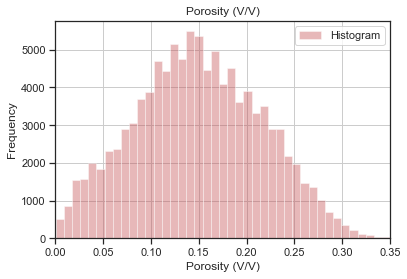

In [12]:
# Font, marker size and axis rotation
edgecolors = 'black'
markersize = 8
alpha = 0.5
size = 18
rotation = 0

savefn = "Hist_Poro_amb.png"
plot_grain_density(mod_df["Porosity (V/V)"], "Porosity (V/V)", 50, 0, 0.35, savefn)

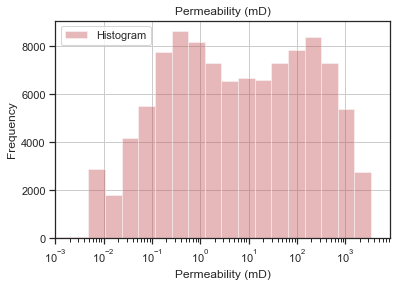

In [13]:
savefn = "Hist_Perm_amb.png"

x= mod_df["Permeability (mD)"]

logbins = np.geomspace(x.min(), x.max(), 20)
plot_grain_density(mod_df["Permeability (mD)"], "Permeability (mD)", logbins, 0.001, x.max()+5000, savefn)
plt.xscale('log')

#### Plot cross-plot of Porosity-Permeability

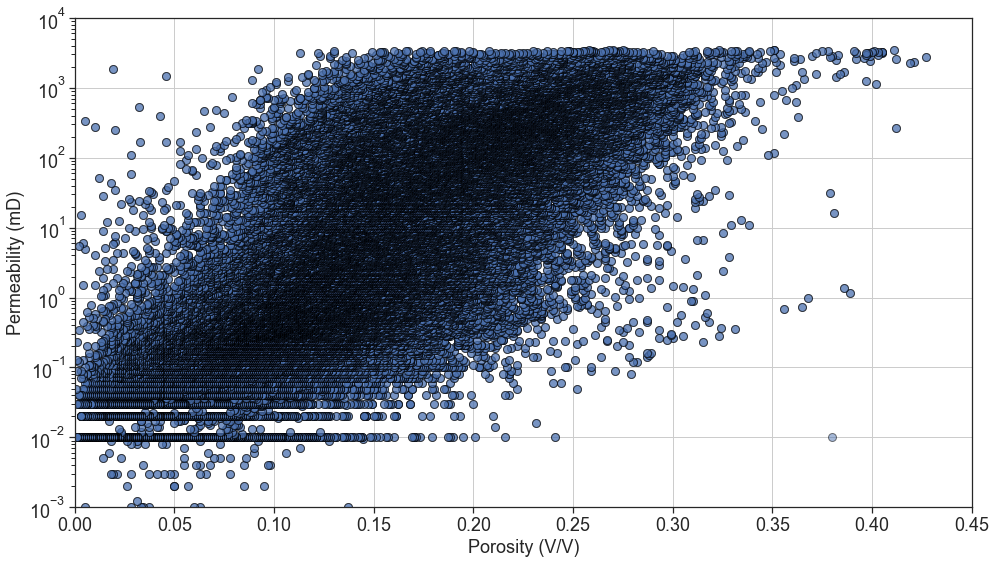

<Figure size 432x288 with 0 Axes>

In [14]:
savefn = "Poro_Perm_amb.png"

xlimit = 0.45
ylimit = 10000

fig = plt.figure(figsize=(14, 8))
sc = plt.scatter(
    mod_df["Porosity (V/V)"],
    mod_df["Permeability (mD)"],
    s = markersize**2,
    alpha=0.5,
    label="Porosity vs Permeability",
    edgecolors = edgecolors,
)  

# Add legends
#ax.add_artist(ax.legend(title='Well Name'))
#ax.legend(*sc.legend_elements("colors", num=6), prop={'size': 20})
plt.xlabel('Porosity (V/V)', fontsize=size)
plt.ylabel('Permeability (mD)', fontsize=size)

plt.xticks(rotation = rotation, fontsize=size)
plt.yticks(rotation = rotation, fontsize=size)
plt.xlim(0, xlimit)
plt.ylim(0.001, ylimit)

plt.yscale('log')

plt.tight_layout()
plt.grid(True)
plt.show()

plt.savefig(savefn, transparent=True)

### K means clustering of Core Data

#### Step 1: Normalise Data Set

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

#### Step 1: Elbow Plot

In [ ]:
mod_df_copy = mod_df.copy()
mod_df_copy.columns.values

In [ ]:
# Select columns to do prediction on
X_drop = mod_df_copy.drop(['Well Name', 'Sample ID', 'Depth (m)', 'NOB (psi)',
                           #'Grain Density (g/cc)', 
                           'Core Type', 'color'], axis = 1)

In [ ]:
distortions = []

min_el = 1
max_el = 10

# A loop runs thorugh your min and max clusters. 
# We dont complicate the K-Means at this stage
# We store an "intertia" number which is the measurement of the distortions in different K clustering solutions

for i in range (min_el,max_el):
    km = KMeans(n_clusters= i, init = "k-means++")
    km.fit(X_drop)
    distortions.append(km.inertia_)  

In [ ]:
# elbow curve
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (5,3), dpi = 150)
plt.plot(range (min_el,max_el), distortions, marker='o', markersize=5,
    markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
plt.title('Elbow for KMeans clustering')

#### Looks like 3 is the optimal number of clusters. Lets do the K means proper now

#### Step 2: K-means Plot

In [ ]:
# This normalizes the data set
scaler = preprocessing.StandardScaler()
scaler.fit(X_drop)
X_drop_Norm = scaler.transform(X_drop)

# Now we convert to a pandas array
#car_norm_price = pd.DataFrame(X_drop_Norm, columns = DF_model_toNorm_colnam, index = DF_model_toNorm_rownam)
#car_norm_price

In [ ]:
# Fitting the K-Means with the optimal number of cluster
k = 3
km = KMeans(n_clusters=k, init = "k-means++", random_state = 0)
km_fit = km.fit(X_drop_Norm)

# Predicting the Classificaiton of the Data
y_pred = km.fit_predict(X_drop_Norm)
display(y_pred)

In [ ]:
# The predicted results should now be converted to a pandas dataframe
y_pred_data = pd.DataFrame({"cluster":y_pred},index = X_drop.index)
y_pred_data

In [ ]:
core_pred = pd.concat([X_drop , y_pred_data], axis = 1)
core_pred

In [ ]:
names = core_pred['cluster'].unique()
c = df_colors[['hex_value']].astype(str).agg(','.join,axis=1).tolist()
colors = dict(zip(names,c))

core_pred['color'] = core_pred['cluster'].apply(lambda x: colors[x])
core_pred = core_pred.sort_values(by = 'Porosity (%)', ascending = True)
core_pred

In [ ]:
pd.crosstab(core_pred['Porosity (%)'], core_pred['cluster'], normalize='index', margins = True)

In [ ]:
filtered_label0 = core_pred[core_pred['cluster'] == 0]
filtered_label1 = core_pred[core_pred['cluster'] == 1]
filtered_label2 = core_pred[core_pred['cluster'] == 2]
#filtered_label3 = core_pred[core_pred['cluster'] == 3]

In [ ]:
fs = 12

#markers - https://matplotlib.org/stable/api/markers_api.html
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (5,3), dpi = 150,)
plt.scatter(filtered_label0['Porosity (%)'], filtered_label0['K (mD)'], marker='o')
plt.scatter(filtered_label1['Porosity (%)'], filtered_label1['K (mD)'], marker='v')
plt.scatter(filtered_label2['Porosity (%)'], filtered_label2['K (mD)'], marker='+')
#plt.scatter(filtered_label3['Porosity (%)'], filtered_label3['K (mD)'], marker='s')

x_pts = list(range(0,20,1))

#Line styles - https://matplotlib.org/2.0.2/api/lines_api.html
p = np.polyfit(np.log(filtered_label0['Porosity (%)']), np.log(filtered_label0['K (mD)']), 1)
f = np.poly1d(p)
plt.semilogy(x_pts, np.exp(p[0] * np.log(x_pts) + p[1]), 'k-', linewidth = 1.5)
plt.text(12.5, 15, r'Equation ={}'.format(f), fontsize = fs/1.5, bbox=dict(facecolor='white', alpha=0.25))

p = np.polyfit(np.log(filtered_label1['Porosity (%)']), np.log(filtered_label1['K (mD)']), 1)
f = np.poly1d(p)
plt.semilogy(x_pts, np.exp(p[0] * np.log(x_pts) + p[1]), 'k--', linewidth = 1.5)
plt.text(6, 0.5, r'Equation ={}'.format(f), fontsize = fs/1.5, bbox=dict(facecolor='white', alpha=0.25))

p = np.polyfit(np.log(filtered_label2['Porosity (%)']), np.log(filtered_label2['K (mD)']), 1)
f = np.poly1d(p)
plt.semilogy(x_pts, np.exp(p[0] * np.log(x_pts) + p[1]), 'k-.', linewidth = 1.5)
plt.text(17.8, 200, r'Equation ={}'.format(f), fontsize = fs/1.5, bbox=dict(facecolor='white', alpha=0.5))

# p = np.polyfit(np.log(filtered_label3['Porosity (%)']), np.log(filtered_label3['K (mD)']), 1)
# f = np.poly1d(p)
# plt.semilogy(filtered_label3['Porosity (%)'], np.exp(p[0] * np.log(filtered_label3['Porosity (%)']) + p[1]), 'k.', linewidth = 1.5)
# plt.text(17.8, 200, r'Equation ={}'.format(f), fontsize = fs/1.5, bbox=dict(facecolor='white', alpha=0.5))

plt.yscale('log')
plt.xlim(0, xlimit)
plt.ylim(1, ylimit)
plt.xticks(fontsize=fs-3)
plt.xlabel('Porosity (%)',fontsize=fs)
plt.ylabel('Permeability (mD)',fontsize=fs)
plt.title('Cluster Distribution',fontsize=fs+2)
plt.grid(True)

plt.savefig('Cluster_Dist.png', transparent=True)

In [ ]:
count = 'Completed Process'
elapsed = (time.time() - start)
print ("%s in %s seconds" % (count,elapsed))